In [71]:
import sys
import os
import pandas as pd
import numpy as np
from datetime import date
import talib
from sklearn.linear_model import *
import json
import warnings
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import datetime as dt
import requests
import sys
import re
import itertools
import os
import talib
import logging
from decimal import Decimal
import io
import sys
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from PIL import Image
import warnings

warnings.filterwarnings("ignore")

dataset_name = "EUR_USD_H1"
threshold = 0
config_path = "/Users/newuser/Projects/robust_algo_trader/settings/config.json"
root_data_dir = "/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data"

# Load the config file
# config_path = "/projects/genomic-ml/da2343/ml_project_2/settings/config.json"
with open(config_path) as f:
    config = json.load(f)

# Get the take_profit and stop_loss levels from the config file
rr_ratio = config["risk_reward_ratio"]
config_settings = config["trading_settings"][dataset_name]
sl = config_settings["stop_loss"]
tp = 3 * sl
start_hr = config_settings["start_hour"]
end_hr = config_settings["end_hour"]
window_size = config["window_size"]

# dataset_path = config_settings["dataset_path"]
device = config["device"]



df = pd.read_csv(f"{root_data_dir}/{dataset_name}_processed_data.csv")
df = df.rename(columns={"time": "Time"})
df['EMA_100'] = ta.EMA(df['Close'], timeperiod=100)
df['ATR'] = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

# remove the first 300 rows
df = df.iloc[300:]


df["Index"] = df.index
y = df[["Close"]]
offset = y.index[0]
df["Time"] = pd.to_datetime(df["Time"])

df = df[df["Time"] >= "2010-01-01 00:00:00"]
trades = []



def create_trade_order(row, position, tp, sl):
    ask_price = row["Close"]
    tp_price = ask_price + tp if position == 1 else ask_price - tp
    sl_price = ask_price - sl if position == 1 else ask_price + sl

    trade_order = {
        "index": row.name,
        "ask_price": ask_price,
        "take_profit_price": tp_price,
        "stop_loss_price": sl_price,
        "position": position,
        # f"SMA_{timeperiod}": row[f"SMA_{timeperiod}"],
        "MACD": row["MACD"],
        "MACD_Signal": row["MACD_Signal"],
        "MACD_Hist": row["MACD_Hist"],
        "MACD_Crossover_Change": row["MACD_Crossover_Change"],
        "RSI": row["RSI"],
        "ATR": row["ATR"],
        "ADX": row["ADX"],
        "AROON_Oscillator": row["AROON_Oscillator"],
        "WILLR": row["WILLR"],
        "OBV": row["OBV"],
        "CCI": row["CCI"],
        "PSAR": row["PSAR"],
        "AD": row["AD"],
        "ADOSC": row["ADOSC"],
        # "VOLUME_RSI": row["VOLUME_RSI"],
        # "MFI": row["MFI"],
        "Time": row["Time"],
        "close_time": None,
        "label": None,
    }
    return trade_order


def is_time_between(start_time, end_time, check_time):
    if start_time < end_time:
        return start_time <= check_time <= end_time
    else:  # crosses midnight
        return check_time >= start_time or check_time <= end_time


try:
    # loop through all rows in the dataframe
    for index, row in df.iloc[window_size:].iterrows():
        # check if there are any open trades
        if len(trades) != 0:
            prev_trade = trades[-1]
            # check if the previous trade was a long trade
            if prev_trade["position"] == 1:
                take_profit_hit = (
                    row["Close"] >= prev_trade["take_profit_price"]
                )
                stop_loss_hit = (
                    row["Close"] <= prev_trade["stop_loss_price"]
                )
                # if take_profit_hit and stop_loss_hit:
                #     print("position = 1")
                #     print("take_profit_hit and stop_loss_hit")
                
                if take_profit_hit and prev_trade["label"] == None:
                    abs_change = abs((row["Close"] - prev_trade["ask_price"]))
                    prev_trade["label"] = 200*abs_change
                    prev_trade["close_time"] = row["Time"]
                    continue
                elif stop_loss_hit and prev_trade["label"] == None:
                    abs_change = abs((row["Close"] - prev_trade["ask_price"]))
                    prev_trade["label"] = -200*abs_change
                    prev_trade["close_time"] = row["Time"]
                    continue
            else:
                take_profit_hit = (
                    row["Close"] <= prev_trade["take_profit_price"]
                )
                stop_loss_hit = (
                    row["Close"] >= prev_trade["stop_loss_price"]
                )
                # if take_profit_hit and stop_loss_hit:
                #     print("position = 0")
                #     print("take_profit_hit and stop_loss_hit")
                    
                if take_profit_hit and prev_trade["label"] == None:
                    abs_change = abs((row["Close"] - prev_trade["ask_price"]))
                    
                    prev_trade["label"] = 200*abs_change
                    prev_trade["close_time"] = row["Time"]
                    continue
                elif stop_loss_hit and prev_trade["label"] == None:
                    abs_change = abs((row["Close"] - prev_trade["ask_price"]))
                    prev_trade["label"] = -200*abs_change
                    prev_trade["close_time"] = row["Time"]
                    continue

            if prev_trade["label"] == None:
                continue

        # if there are no open trades, check if there is a crossover
        macd_crossover_change = row["MACD_Crossover_Change"]
        current_time = row["Time"]
        if (macd_crossover_change > 0 or macd_crossover_change < 0) and is_time_between(
            start_hr, end_hr, current_time.hour
        ):
            if (
                (row["MACD_Crossover_Change"] > 0)
                and (row["Close"] > row["EMA_100"])
            ):
                current_position = 1  # long
            elif (
                (row["MACD_Crossover_Change"] < 0)
                and (row["Close"] < row["EMA_100"])
            ):
                current_position = 0  # short
            else:
                continue

            # TODO: Dummy
            # sl from ATR
            sl = row["ATR"] 
            tp = 3 * sl
            local_order = create_trade_order(row, current_position, tp, sl)
            trades.append(local_order)

            # # TODO: ML
            # subset_df = df.loc[(index-window_size+1):(index)]
            # # output_item = save_setup_graph(subset_df, current_position, index)
            # output_item = 0.99
            # pred = 1 if output_item > threshold else 0
            # # use that to execute a trade order
            # if pred == 1:
            #     local_order = create_trade_order(row, current_position, tp, sl)
            #     trades.append(local_order)
except Exception as e:
    print(e)

trades_df = pd.DataFrame(trades)

<Axes: >

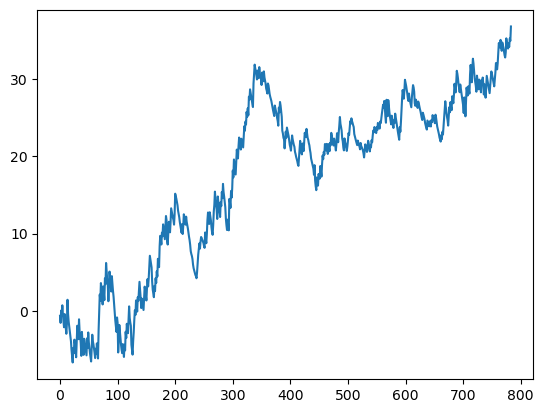

In [72]:
# using the label column find the cumulative sum
trades_df["cumulative_sum"] = trades_df["label"].cumsum()
trades_df["cumulative_sum"].plot()

In [73]:
trades_df

,index,ask_price,take_profit_price,stop_loss_price,position,MACD,MACD_Signal,MACD_Hist,MACD_Crossover_Change,RSI,...,WILLR,OBV,CCI,PSAR,AD,ADOSC,Time,close_time,label,cumulative_sum
0,33041,1.45398,1.463164,1.450919,1,0.000404,0.000293,0.000111,2.0,59.620898,...,-6.926407,-274967.0,238.921575,1.446389,-3.122479e+05,1775.785906,2010-01-12 15:00:00+00:00,2010-01-12 17:00:00+00:00,-0.648,-0.648
1,33237,1.41072,1.401503,1.413792,0,0.000442,0.000499,-0.000057,-2.0,46.757861,...,-74.358974,-341004.0,-74.216646,1.408716,-3.220704e+05,-1660.558953,2010-01-22 13:00:00+00:00,2010-01-22 16:00:00+00:00,-0.916,-1.564
2,33317,1.40410,1.396618,1.406594,0,-0.001190,-0.001161,-0.000029,-2.0,39.550711,...,-74.468085,-334993.0,-111.410566,1.402568,-3.261128e+05,-786.558432,2010-01-27 15:00:00+00:00,2010-01-28 15:00:00+00:00,1.600,0.036
3,33365,1.38990,1.381751,1.392616,0,-0.001595,-0.001388,-0.000207,-2.0,30.160781,...,-98.004435,-367254.0,-178.699187,1.398582,-3.251759e+05,-2706.186845,2010-01-29 15:00:00+00:00,2010-02-01 20:00:00+00:00,-0.644,-0.608
4,33441,1.39420,1.387798,1.396334,0,0.001143,0.001361,-0.000219,-2.0,42.177206,...,-98.368298,-361892.0,-72.590411,1.402640,-3.351213e+05,-1770.358054,2010-02-03 13:00:00+00:00,2010-02-04 06:00:00+00:00,1.316,0.708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,120962,1.09725,1.100525,1.096158,1,0.000348,0.000285,0.000063,2.0,65.907830,...,-3.807107,-1482351.0,166.071106,1.093516,-2.865264e+06,841.554429,2023-11-28 13:00:00+00:00,2023-11-28 16:00:00+00:00,0.658,34.590
780,121034,1.08676,1.082283,1.088252,0,-0.001220,-0.001161,-0.000059,-2.0,29.828327,...,-97.413793,-1511595.0,-216.444018,1.090633,-2.889793e+06,-3650.246582,2023-12-01 13:00:00+00:00,2023-12-01 18:00:00+00:00,-0.432,34.158
781,121059,1.08398,1.078898,1.085674,0,-0.000884,-0.000754,-0.000130,-2.0,33.865028,...,-69.728916,-1527982.0,-270.063140,1.088905,-2.902460e+06,-2881.165012,2023-12-04 14:00:00+00:00,2023-12-05 16:00:00+00:00,1.076,35.234
782,121179,1.07532,1.071496,1.076595,0,-0.000260,-0.000243,-0.000016,-2.0,41.633296,...,-73.504274,-1610215.0,-193.909053,1.078580,-2.906044e+06,1284.021276,2023-12-11 14:00:00+00:00,2023-12-12 03:00:00+00:00,-0.304,34.930


In [ ]:
import sys
import os
import pandas as pd
import numpy as np
from datetime import date
import talib
from sklearn.linear_model import *
import json
import warnings
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import datetime as dt
import requests
import sys
import re
import itertools
import os
import talib
import logging
from decimal import Decimal
import io
import sys
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from PIL import Image
import warnings

warnings.filterwarnings("ignore")

dataset_name = "EUR_USD_H1"
threshold = 0
config_path = "/Users/newuser/Projects/robust_algo_trader/settings/config.json"
root_data_dir = "/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data"

# Load the config file
# config_path = "/projects/genomic-ml/da2343/ml_project_2/settings/config.json"
with open(config_path) as f:
    config = json.load(f)

# Get the take_profit and stop_loss levels from the config file
rr_ratio = config["risk_reward_ratio"]
config_settings = config["trading_settings"][dataset_name]
sl = config_settings["stop_loss"]
tp = 1 * sl
start_hr = config_settings["start_hour"]
end_hr = config_settings["end_hour"]
window_size = config["window_size"]

# dataset_path = config_settings["dataset_path"]
device = config["device"]
# ml_model_path = config["paths"]["model_80_dir"]
ml_model_path = config["paths"]["model_90_dir"]



# Set a random seed for reproducibility
seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


# Define the model
class CNNet(nn.Module):
    def __init__(self):
        super(CNNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        # self.dropout = nn.Dropout(0.25)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(86528, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


# Load the trained model
cnn = CNNet()
cnn.load_state_dict(torch.load(ml_model_path))
cnn.to(device)
cnn.eval()


df = pd.read_csv(f"{root_data_dir}/{dataset_name}_processed_data.csv")
df = df.rename(columns={"time": "Time"})
df["Index"] = df.index
y = df[["Close"]]
offset = y.index[0]

df["Time"] = pd.to_datetime(df["Time"])
trades = []


def save_setup_graph(subset_df, position, index):
    green_df = subset_df[subset_df["Close"] > subset_df["Open"]].copy()
    green_df["Height"] = green_df["Close"] - green_df["Open"]
    red_df = subset_df[subset_df["Close"] < subset_df["Open"]].copy()
    red_df["Height"] = red_df["Open"] - red_df["Close"]

    # if green_df or red_df is empty, then return
    # if the length of green_df and red_df is less than the window_size, then return
    if green_df.empty and red_df.empty:
        return 0

    plt.switch_backend("Agg")
    fig = plt.figure(figsize=(8, 3))

    ##Grey Lines
    plt.vlines(
        x=green_df["Index"], ymin=green_df["Low"], ymax=green_df["High"], color="green"
    )
    plt.vlines(
        x=red_df["Index"], ymin=red_df["Low"], ymax=red_df["High"], color="orangered"
    )
    ##Green Candles
    plt.bar(
        x=green_df["Index"],
        height=green_df["Height"],
        bottom=green_df["Open"],
        color="green",
    )
    ##Red Candles
    plt.bar(
        x=red_df["Index"],
        height=red_df["Height"],
        bottom=red_df["Close"],
        color="orangered",
    )

    plt.plot(subset_df["SMA_20"], label="SMA_20")
    plt.plot(subset_df["SMA_30"], label="SMA_30")

    close_price = subset_df["Close"].iloc[-1]

    sl_eps = sl
    tp_eps = tp

    if position == 1:
        plt.axhspan(
            close_price, close_price + tp_eps, facecolor="green", xmin=0.96, alpha=0.9
        )
        plt.axhspan(
            close_price - sl_eps,
            close_price,
            facecolor="orangered",
            xmin=0.96,
            alpha=0.9,
        )
    else:
        plt.axhspan(
            close_price,
            close_price + sl_eps,
            facecolor="orangered",
            xmin=0.96,
            alpha=0.9,
        )
        plt.axhspan(
            close_price - tp_eps, close_price, facecolor="green", xmin=0.96, alpha=0.9
        )
    plt.xticks([])
    plt.yticks([])
    plt.box(False)

    buf = io.BytesIO()
    plt.savefig(buf, dpi=128, bbox_inches="tight", format="png")
    buf.seek(0)
    image = Image.open(buf).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    # Get the model output
    output = cnn(image)
    output_item = output.item()
    buf.close()
    # close the figure
    plt.close()
    return output_item


def create_trade_order(row, position, tp, sl):
    ask_price = row["Close"]
    tp_price = ask_price + tp if position == 1 else ask_price - tp
    sl_price = ask_price - sl if position == 1 else ask_price + sl

    trade_order = {
        "index": row.name,
        "ask_price": ask_price,
        "take_profit_price": tp_price,
        "stop_loss_price": sl_price,
        "position": position,
        # f"SMA_{timeperiod}": row[f"SMA_{timeperiod}"],
        "MACD": row["MACD"],
        "MACD_Signal": row["MACD_Signal"],
        "MACD_Hist": row["MACD_Hist"],
        "MACD_Crossover_Change": row["MACD_Crossover_Change"],
        "RSI": row["RSI"],
        "ATR": row["ATR"],
        "ADX": row["ADX"],
        "AROON_Oscillator": row["AROON_Oscillator"],
        "WILLR": row["WILLR"],
        "OBV": row["OBV"],
        "CCI": row["CCI"],
        "PSAR": row["PSAR"],
        "AD": row["AD"],
        "ADOSC": row["ADOSC"],
        # "VOLUME_RSI": row["VOLUME_RSI"],
        # "MFI": row["MFI"],
        "Time": row["Time"],
        "close_time": None,
        "label": None,
    }
    return trade_order


def is_time_between(start_time, end_time, check_time):
    if start_time < end_time:
        return start_time <= check_time <= end_time
    else:  # crosses midnight
        return check_time >= start_time or check_time <= end_time


try:
    # loop through all rows in the dataframe
    for index, row in df.iloc[window_size:].iterrows():
        # check if there are any open trades
        if len(trades) != 0:
            prev_trade = trades[-1]
            # check if the previous trade was a long trade
            if prev_trade["position"] == 1:
                take_profit_hit = (
                    row["Close"] >= prev_trade["take_profit_price"]
                    or row["High"] >= prev_trade["take_profit_price"]
                    or row["Low"] >= prev_trade["take_profit_price"]
                    or row["Open"] >= prev_trade["take_profit_price"]
                )
                stop_loss_hit = (
                    row["Close"] <= prev_trade["stop_loss_price"]
                    or row["High"] <= prev_trade["stop_loss_price"]
                    or row["Low"] <= prev_trade["stop_loss_price"]
                    or row["Open"] <= prev_trade["stop_loss_price"]
                )
                if take_profit_hit and stop_loss_hit:
                    print("position = 1")
                    print("take_profit_hit and stop_loss_hit")
                
                if take_profit_hit and prev_trade["label"] == None:
                    prev_trade["label"] = 1
                    prev_trade["close_time"] = row["Time"]
                    continue
                elif stop_loss_hit and prev_trade["label"] == None:
                    prev_trade["label"] = 0
                    prev_trade["close_time"] = row["Time"]
                    continue
            else:
                take_profit_hit = (
                    row["Close"] <= prev_trade["take_profit_price"]
                    or row["High"] <= prev_trade["take_profit_price"]
                    or row["Low"] <= prev_trade["take_profit_price"]
                    or row["Open"] <= prev_trade["take_profit_price"]
                )
                stop_loss_hit = (
                    row["Close"] >= prev_trade["stop_loss_price"]
                    or row["High"] >= prev_trade["stop_loss_price"]
                    or row["Low"] >= prev_trade["stop_loss_price"]
                    or row["Open"] >= prev_trade["stop_loss_price"]
                )
                if take_profit_hit and stop_loss_hit:
                    print("position = 0")
                    print("take_profit_hit and stop_loss_hit")
                    
                if take_profit_hit and prev_trade["label"] == None:
                    prev_trade["label"] = 1
                    prev_trade["close_time"] = row["Time"]
                    continue
                elif stop_loss_hit and prev_trade["label"] == None:
                    prev_trade["label"] = 0
                    prev_trade["close_time"] = row["Time"]
                    continue

            if prev_trade["label"] == None:
                continue

        # if there are no open trades, check if there is a crossover
        macd_crossover_change = row["MACD_Crossover_Change"]
        current_time = row["Time"]
        if (macd_crossover_change > 0 or macd_crossover_change < 0) and is_time_between(
            start_hr, end_hr, current_time.hour
        ):
            if (
                (row["MACD_Crossover_Change"] > 0)
                and (row["Close"] > row["SMA_20"])
                and (row["Close"] > row["SMA_30"])
            ):
                current_position = 1  # long
            elif (
                (row["MACD_Crossover_Change"] < 0)
                and (row["Close"] < row["SMA_20"])
                and (row["Close"] < row["SMA_30"])
            ):
                current_position = 0  # short
            else:
                continue

            # TODO: Dummy
            local_order = create_trade_order(row, current_position, tp, sl)
            trades.append(local_order)

            # # TODO: ML
            # subset_df = df.loc[(index-window_size+1):(index)]
            # # output_item = save_setup_graph(subset_df, current_position, index)
            # output_item = 0.99
            # pred = 1 if output_item > threshold else 0
            # # use that to execute a trade order
            # if pred == 1:
            #     local_order = create_trade_order(row, current_position, tp, sl)
            #     trades.append(local_order)
except Exception as e:
    print(e)

trades_df = pd.DataFrame(trades)

# trades_df['Time'] = pd.to_datetime(trades_df['Time'])
# trades_df.to_csv("/projects/genomic-ml/da2343/ml_project_2/cnn/results/1_dummy.csv", encoding='utf-8', index=False)
# print("Done!")

# trades_df["Time"] = pd.to_datetime(trades_df["Time"])
# trades_df["Year"] = trades_df["Time"].dt.year
# trades_df["Return"] = np.where(trades_df["label"] == 1, 2, -1)
# max_drawdown_df = trades_df.copy()
# max_drawdown_df = max_drawdown_df[["Year", "Return", "label"]]
# max_drawdown = 0
# max_drawdown_column = []
# for index, row in max_drawdown_df.iterrows():
#     if row["Return"] == 2:
#         max_drawdown = 0
#     elif row["Return"] == -1:
#         max_drawdown += 1
#     max_drawdown_column.append(max_drawdown)
# max_drawdown_df["Max Drawdown"] = max_drawdown_column
# max_drawdown_df = (
#     max_drawdown_df.groupby(["Year"]).agg({"Max Drawdown": "max"}).reset_index()
# )
# trades_df = (
#     trades_df.groupby(["Year"]).agg({"Return": "sum", "label": "count"}).reset_index()
# )
# trades_df["trades"] = trades_df["label"]
# trades_df.drop(["label"], axis=1, inplace=True)
# trades_df = pd.merge(trades_df, max_drawdown_df, on="Year")
# trades_df[f"{dataset_name} Percent Return"] = (
#     trades_df["Return"] / trades_df["trades"]
# ) * 100
# trades_df = trades_df[trades_df["Year"] > 2007].copy()
# portfolio_df = pd.DataFrame()
# portfolio_df["Mean Return"] = [trades_df["Return"].mean()]
# portfolio_df["Mean Trades"] = [trades_df["trades"].mean()]
# portfolio_df["Mean Max Drawdown"] = [trades_df["Max Drawdown"].mean()]
# portfolio_df["Mean Percent Return"] = [
#     trades_df[f"{dataset_name} Percent Return"].mean()
# ]
# portfolio_df["Take Profit"] = tp
# portfolio_df["Stop Loss"] = sl
# portfolio_df["Dataset"] = dataset_name
# portfolio_df.to_csv(f"results/{param_row}.csv", encoding="utf-8", index=False)

In [36]:
import pandas as pd
import talib
import matplotlib.pyplot as plt

df = pd.read_csv(f"{root_data_dir}/{dataset_name}_processed_data.csv")
df = df.rename(columns={"time": "Time"})
df["Index"] = df.index
y = df[["Close"]]
offset = y.index[0]
df["Time"] = pd.to_datetime(df["Time"])

df

,Time,Open,High,Low,Close,Volume,SMA_20,SMA_30,SMA_50,SMA_100,...,STOCH_D,WILLR,BBANDS_Upper,BBANDS_Middle,BBANDS_Lower,AD,ADOSC,VOLUME_RSI,MFI,Index
0,2002-12-23 20:00:00+00:00,1.02630,1.02630,1.02630,1.02630,1,1.015117,1.008437,1.006395,0.993653,...,61.456579,-10.669975,1.027943,1.026900,1.025857,0.000000e+00,0.000000,0.000000,50.104100,0
1,2002-12-24 20:00:00+00:00,1.03010,1.03010,1.03010,1.03010,1,1.016787,1.009393,1.007311,0.994132,...,55.247931,-0.000000,1.030265,1.027640,1.025015,0.000000e+00,0.000000,0.000000,50.170706,1
2,2002-12-25 11:00:00+00:00,1.03225,1.03225,1.03225,1.03225,1,1.018570,1.010562,1.008160,0.994631,...,54.149271,-0.000000,1.033091,1.028610,1.024129,0.000000e+00,0.000000,0.000000,57.298376,2
3,2002-12-26 20:00:00+00:00,1.03740,1.03740,1.03740,1.03740,1,1.020415,1.011922,1.008974,0.995168,...,73.170732,-0.000000,1.038559,1.030730,1.022901,0.000000e+00,0.000000,0.000000,64.407441,3
4,2002-12-27 20:00:00+00:00,1.04390,1.04390,1.04390,1.04390,1,1.022570,1.013492,1.009908,0.995638,...,88.888889,-0.000000,1.046225,1.033990,1.021755,0.000000e+00,0.000000,0.000000,71.500226,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121398,2023-12-22 17:00:00+00:00,1.10073,1.10166,1.10001,1.10160,4535,1.100914,1.100389,1.098228,1.096607,...,44.293029,-52.586207,1.104161,1.101996,1.099831,-2.807602e+06,310.115072,49.220514,54.594636,121398
121399,2023-12-22 18:00:00+00:00,1.10159,1.10194,1.10110,1.10133,3226,1.100936,1.100498,1.098342,1.096692,...,32.904725,-58.405172,1.103680,1.101682,1.099684,-2.809061e+06,-85.786070,45.593752,55.611571,121399
121400,2023-12-22 19:00:00+00:00,1.10134,1.10157,1.10022,1.10155,3843,1.100985,1.100579,1.098457,1.096793,...,30.804334,-53.663793,1.101897,1.101272,1.100647,-2.805332e+06,946.595530,47.555325,54.258512,121400
121401,2023-12-22 20:00:00+00:00,1.10156,1.10160,1.10079,1.10128,2207,1.101025,1.100648,1.098563,1.096887,...,35.742727,-59.482759,1.101911,1.101300,1.100689,-2.804869e+06,1430.260350,43.116370,56.925667,121401


In [40]:
# Import libraries
import pandas as pd
import numpy as np
import talib as ta

# Read the ohlcv data
df = pd.read_csv(f'/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data/EUR_USD_H1_processed_data.csv')
df = df.rename(columns={"time": "Time"})
df["Index"] = df.index
y = df[["Close"]]
offset = y.index[0]
df["Time"] = pd.to_datetime(df["Time"])
df

,Time,Open,High,Low,Close,Volume,SMA_20,SMA_30,SMA_50,SMA_100,...,STOCH_D,WILLR,BBANDS_Upper,BBANDS_Middle,BBANDS_Lower,AD,ADOSC,VOLUME_RSI,MFI,Index
0,2002-12-23 20:00:00+00:00,1.02630,1.02630,1.02630,1.02630,1,1.015117,1.008437,1.006395,0.993653,...,61.456579,-10.669975,1.027943,1.026900,1.025857,0.000000e+00,0.000000,0.000000,50.104100,0
1,2002-12-24 20:00:00+00:00,1.03010,1.03010,1.03010,1.03010,1,1.016787,1.009393,1.007311,0.994132,...,55.247931,-0.000000,1.030265,1.027640,1.025015,0.000000e+00,0.000000,0.000000,50.170706,1
2,2002-12-25 11:00:00+00:00,1.03225,1.03225,1.03225,1.03225,1,1.018570,1.010562,1.008160,0.994631,...,54.149271,-0.000000,1.033091,1.028610,1.024129,0.000000e+00,0.000000,0.000000,57.298376,2
3,2002-12-26 20:00:00+00:00,1.03740,1.03740,1.03740,1.03740,1,1.020415,1.011922,1.008974,0.995168,...,73.170732,-0.000000,1.038559,1.030730,1.022901,0.000000e+00,0.000000,0.000000,64.407441,3
4,2002-12-27 20:00:00+00:00,1.04390,1.04390,1.04390,1.04390,1,1.022570,1.013492,1.009908,0.995638,...,88.888889,-0.000000,1.046225,1.033990,1.021755,0.000000e+00,0.000000,0.000000,71.500226,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121398,2023-12-22 17:00:00+00:00,1.10073,1.10166,1.10001,1.10160,4535,1.100914,1.100389,1.098228,1.096607,...,44.293029,-52.586207,1.104161,1.101996,1.099831,-2.807602e+06,310.115072,49.220514,54.594636,121398
121399,2023-12-22 18:00:00+00:00,1.10159,1.10194,1.10110,1.10133,3226,1.100936,1.100498,1.098342,1.096692,...,32.904725,-58.405172,1.103680,1.101682,1.099684,-2.809061e+06,-85.786070,45.593752,55.611571,121399
121400,2023-12-22 19:00:00+00:00,1.10134,1.10157,1.10022,1.10155,3843,1.100985,1.100579,1.098457,1.096793,...,30.804334,-53.663793,1.101897,1.101272,1.100647,-2.805332e+06,946.595530,47.555325,54.258512,121400
121401,2023-12-22 20:00:00+00:00,1.10156,1.10160,1.10079,1.10128,2207,1.101025,1.100648,1.098563,1.096887,...,35.742727,-59.482759,1.101911,1.101300,1.100689,-2.804869e+06,1430.260350,43.116370,56.925667,121401


In [41]:


# Calculate the MACD, MACD signal and MACD histogram
df['MACD'], df['MACD_signal'], df['MACD_hist'] = ta.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

# Calculate the 100-period EMA for trend filter
df['EMA_100'] = ta.EMA(df['Close'], timeperiod=100)

# Calculate the ATR for trailing stop loss
df['ATR'] = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

# Define the entry and exit signals
df['Buy'] = np.where((df['MACD'] > df['MACD_signal']) & (df['Close'] > df['EMA_100']), 1, 0)
df['Sell'] = np.where((df['MACD'] < df['MACD_signal']) & (df['Close'] < df['EMA_100']), -1, 0)
df['Signal'] = df['Buy'] + df['Sell']

In [48]:
df

,Time,Open,High,Low,Close,Volume,SMA_20,SMA_30,SMA_50,SMA_100,...,ADOSC,VOLUME_RSI,MFI,Index,MACD_signal,MACD_hist,EMA_100,Buy,Sell,Signal
0,2002-12-23 20:00:00+00:00,1.02630,1.02630,1.02630,1.02630,1,1.015117,1.008437,1.006395,0.993653,...,0.000000,0.000000,50.104100,0,NaN,NaN,NaN,0,0,0
1,2002-12-24 20:00:00+00:00,1.03010,1.03010,1.03010,1.03010,1,1.016787,1.009393,1.007311,0.994132,...,0.000000,0.000000,50.170706,1,NaN,NaN,NaN,0,0,0
2,2002-12-25 11:00:00+00:00,1.03225,1.03225,1.03225,1.03225,1,1.018570,1.010562,1.008160,0.994631,...,0.000000,0.000000,57.298376,2,NaN,NaN,NaN,0,0,0
3,2002-12-26 20:00:00+00:00,1.03740,1.03740,1.03740,1.03740,1,1.020415,1.011922,1.008974,0.995168,...,0.000000,0.000000,64.407441,3,NaN,NaN,NaN,0,0,0
4,2002-12-27 20:00:00+00:00,1.04390,1.04390,1.04390,1.04390,1,1.022570,1.013492,1.009908,0.995638,...,0.000000,0.000000,71.500226,4,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121398,2023-12-22 17:00:00+00:00,1.10073,1.10166,1.10001,1.10160,4535,1.100914,1.100389,1.098228,1.096607,...,310.115072,49.220514,54.594636,121398,0.001061,-0.000103,1.096834,0,0,0
121399,2023-12-22 18:00:00+00:00,1.10159,1.10194,1.10110,1.10133,3226,1.100936,1.100498,1.098342,1.096692,...,-85.786070,45.593752,55.611571,121399,0.001025,-0.000143,1.096924,0,0,0
121400,2023-12-22 19:00:00+00:00,1.10134,1.10157,1.10022,1.10155,3843,1.100985,1.100579,1.098457,1.096793,...,946.595530,47.555325,54.258512,121400,0.000986,-0.000155,1.097015,0,0,0
121401,2023-12-22 20:00:00+00:00,1.10156,1.10160,1.10079,1.10128,2207,1.101025,1.100648,1.098563,1.096887,...,1430.260350,43.116370,56.925667,121401,0.000941,-0.000182,1.097100,0,0,0


In [58]:


# Initialize the variables for position, entry price and stop loss
position = 0
entry_price = 0
stop_loss = 0

# Create a list to store the trade results
trades = []

# Loop through the data and simulate the trading logic
for i, row in df.iterrows():
    # If there is no position, check for entry signal
    if position == 0:
        if row['Signal'] == 1: # Buy signal
            position = 1 # Enter long position
            entry_price = row['Close'] # Record the entry price
            stop_loss = entry_price - 2 * row['ATR'] # Set the initial stop loss
            trades.append(['Buy', i, entry_price, 0]) # Append the trade details to the list with zero PnL
        elif row['Signal'] == -1: # Sell signal
            position = -1 # Enter short position
            entry_price = row['Close'] # Record the entry price
            stop_loss = entry_price + 2 * row['ATR'] # Set the initial stop loss
            trades.append(['Sell', i, entry_price, 0]) # Append the trade details to the list with zero PnL
    # If there is a long position, check for exit signal or stop loss
    elif position == 1:
        if row['Signal'] == -1: # Sell signal
            position = 0 # Exit the position
            exit_price = row['Close'] # Record the exit price
            pnl = exit_price - entry_price # Calculate the PnL
            trades.append(['Sell', i, exit_price, pnl]) # Append the trade details to the list with PnL
        elif row['Low'] < stop_loss: # Stop loss hit
            position = 0 # Exit the position
            exit_price = stop_loss # Record the exit price
            pnl = exit_price - entry_price # Calculate the PnL
            trades.append(['Sell', i, exit_price, pnl]) # Append the trade details to the list with PnL
        else: # No exit signal or stop loss
            stop_loss = max(stop_loss, entry_price + 2* row['ATR']) # Update the trailing stop loss
    # If there is a short position, check for exit signal or stop loss
    elif position == -1:
        if row['Signal'] == 1: # Buy signal
            position = 0 # Exit the position
            exit_price = row['Close'] # Record the exit price
            pnl = entry_price - exit_price # Calculate the PnL
            trades.append(['Buy', i, exit_price, pnl]) # Append the trade details to the list with PnL
        elif row['High'] > stop_loss: # Stop loss hit
            position = 0 # Exit the position
            exit_price = stop_loss # Record the exit price
            pnl = entry_price - exit_price # Calculate the PnL
            trades.append(['Buy', i, exit_price, pnl]) # Append the trade details to the list with PnL
        else: # No exit signal or stop loss
            stop_loss = min(stop_loss, entry_price -2*row['ATR']) # Update the trailing stop loss

# Convert the list of trades to a dataframe
trades_df = pd.DataFrame(trades, columns=['Action', 'Date', 'Price', 'PnL'])

# Print the trades
print(trades_df)


      Action    Date     Price       PnL
0       Sell      99  1.070700  0.000000
1        Buy     100  1.077200 -0.006500
2        Buy     101  1.079000  0.000000
3       Sell     103  1.087149  0.008149
4        Buy     104  1.077200  0.000000
...      ...     ...       ...       ...
46565   Sell  121384  1.102206  0.002396
46566    Buy  121392  1.102580  0.000000
46567   Sell  121394  1.105022  0.002442
46568    Buy  121395  1.103600  0.000000
46569   Sell  121396  1.100911 -0.002689

[46570 rows x 4 columns]


In [59]:
trades_df

,Action,Date,Price,PnL
0,Sell,99,1.070700,0.000000
1,Buy,100,1.077200,-0.006500
2,Buy,101,1.079000,0.000000
3,Sell,103,1.087149,0.008149
4,Buy,104,1.077200,0.000000
...,...,...,...,...
46565,Sell,121384,1.102206,0.002396
46566,Buy,121392,1.102580,0.000000
46567,Sell,121394,1.105022,0.002442
46568,Buy,121395,1.103600,0.000000


<Axes: >

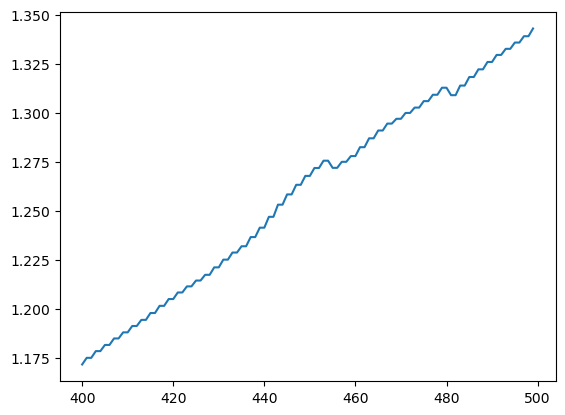

In [57]:
# using the label column find the cumulative sum
trades_df["cumulative_sum"] = trades_df["PnL"].cumsum()
#plot first 100 trades
trades_df["cumulative_sum"].iloc[400:500].plot()
# trades_df["cumulative_sum"].plot()